## Exploratory Data analysis

We will be looking at:
* Unique products
* Missing values
* Number of products by category
* Number of products by brand
* Price v.s. category
* Price v.s. brand
* Price v.s. ingredient
    * Is price related to the number of ingredient?
    * Is price related to the quality of ingredient?
* Price v.s. ingredient category
    * What kind of ingredient is more associated with expensive products?
    * Do those categories have higher rating?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../utilities')
from data_utils import *

sns.set_palette("Set2")

#### Read cleaned data

In [2]:
skin_care_df = pd.read_csv('../data_cleaning/skin_care_cleaned.csv')
body_care_df = pd.read_csv('../data_cleaning/body_care_cleaned.csv')
makeup_df = pd.read_csv('../data_cleaning/makeup_cleaned.csv')

#### Brief look

First, we note that each product can belong to different product categories, for example "Even Skin Vitamin C Cream" belongs to both nighttime moisturizer and vitamin C products, it is stored as two separate rows in the dataframe.

In [3]:
skin_care_df.iloc[:,:6].loc[skin_care_df['product_names']=='Even Skin Vitamin C Cream']

,product_names,product_category,brand,ingredient,size,price
2907,Even Skin Vitamin C Cream,Nighttime Moisturizer,Trish McEvoy,"Cyclomethicone, Polysilicone-11, Petrolatum,...",1.00 fl. oz.,75.0
5091,Even Skin Vitamin C Cream,Vitamin C,Trish McEvoy,"Cyclomethicone, Polysilicone-11, Petrolatum,...",1.00 fl. oz.,75.0


We can see in the skin care data frame, we have 5105 rows but only 4810 unique products.

In [4]:
print('skin care data frame shape (# of records): ', skin_care_df.shape[0])
print('number of unique products:', skin_care_df['product_names'].nunique())

skin care data frame shape (# of records):  5105
number of unique products: 4810


And we can also find out that there are 4345 products that belongs to just 1 category, 419 products belongs to 2 categories ... There is even 1 product that belongs to four categories. We should keep this in mind while counting products.

In [5]:
pd.Series(skin_care_df['product_names'].value_counts().value_counts(), name='number of categories')

1    4535
2     256
3      18
4       1
Name: number of categories, dtype: int64

#### missing values

Now let's check missing values.

* For skin care and body care products, there are a lot of products don't have active ingredient. We won't worry too much about that: active ingredients are usually sunscreen actives or exfoliant, only certain type of products have that.

* Makeup products have much more missing information compare to skin care and body care. 

In [6]:
print('total number of rows:',skin_care_df.shape[0])
print('missing value in skin care products:')
missing = skin_care_df.isnull().sum().sort_values(ascending=False)
print(missing.loc[missing>0],'\n')

print('total number of rows:',body_care_df.shape[0])
print('missing value in body care products:')
missing = body_care_df.isnull().sum().sort_values(ascending=False)
print(missing.loc[missing>0],'\n')

print('total number of rows:',makeup_df.shape[0])
print('missing value in makeup products:')
missing = makeup_df.isnull().sum().sort_values(ascending=False)
print(missing.loc[missing>0],'\n')

total number of rows: 5105
missing value in skin care products:
active_mean_rating         4119
active_ingredient          4119
size_unit                   215
inactive_mean_rating_w2     118
ingredient                  118
inactive_ingredient         118
inactive_mean_rating_w1     118
inactive_mean_rating        118
size                        112
size_num                    112
avg_price                   112
claims                      106
dtype: int64 

total number of rows: 420
missing value in body care products:
active_mean_rating         372
active_ingredient          372
size_unit                   10
inactive_mean_rating_w2      8
ingredient                   8
inactive_ingredient          8
inactive_mean_rating_w1      8
inactive_mean_rating         8
size                         6
size_num                     6
avg_price                    6
claims                       5
dtype: int64 

total number of rows: 2629
missing value in makeup products:
active_mean_rating        

It seems most missing values are in eye and lip makeups.

In [7]:
tmp_df = makeup_df[['product_category','ingredient']].copy(deep=True)
tmp_df['missing ingredient'] = tmp_df['ingredient'].isnull()
tmp_df = tmp_df.groupby('product_category')['missing ingredient'].sum().sort_values(ascending=False)
tmp_df.name = 'number of missing ingredients'
print(tmp_df)

product_category
Lip Stick/Gloss/Liner         283.0
Mascara                       253.0
Eyeliner                      226.0
Eyeshadow                     152.0
Concealer & Corrector         125.0
Blush                          81.0
Highlighter                    80.0
Eyebrow                        65.0
Bronzer                        57.0
Face Powder                    31.0
Foundation                     24.0
Eyeshadow Primer & Base        21.0
Foundation Primer              18.0
Eyelash Primer & Treatment     12.0
Contour                         3.0
Setting Spray                   0.0
Name: number of missing ingredients, dtype: float64


#### Look at how many products (data points) are in each product category.

number of skin care categories 17


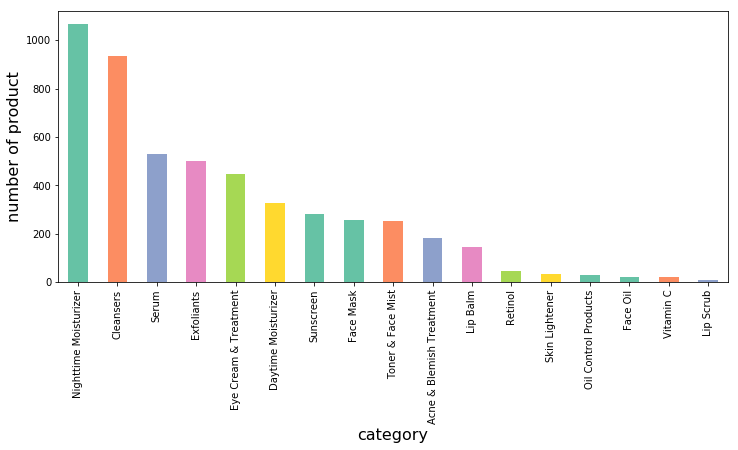

number of body care categories 6


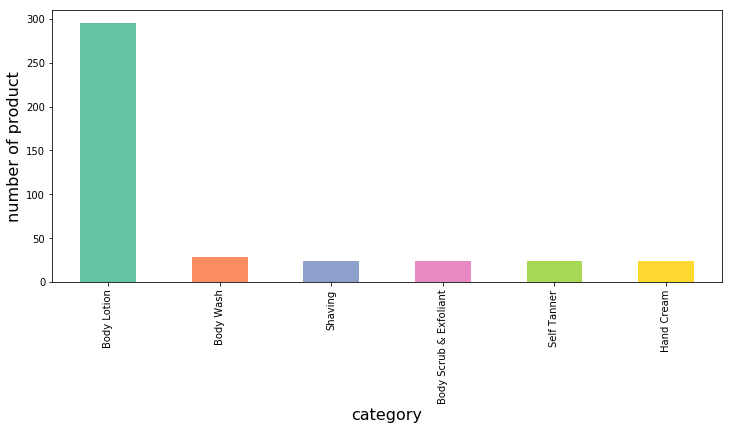

number of makeup categories 16


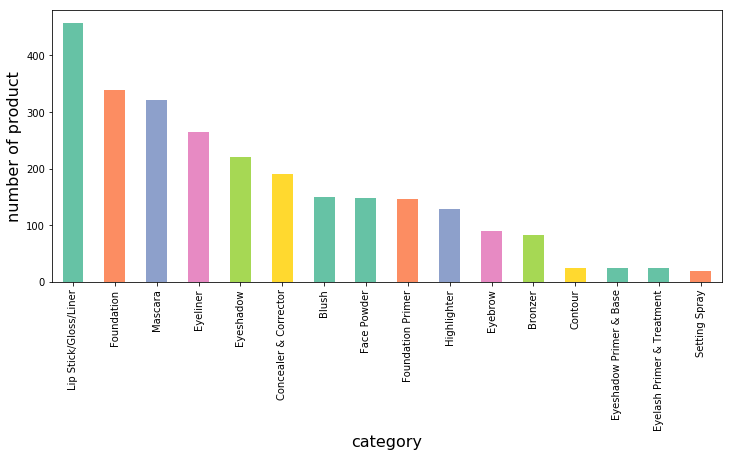

In [8]:
def report_category(df, message):
    print ('number of %s categories'%message, df['product_category'].nunique())
    count = df['product_category'].value_counts()
    plt.figure(figsize=(12,5))
    count.plot.bar()
    plt.xlabel('category', fontsize=16)
    plt.ylabel('number of product', fontsize=16)
    plt.show()
    
report_category(skin_care_df, 'skin care')
report_category(body_care_df, 'body care')
report_category(makeup_df, 'makeup')

#### Look at how many products (data points) are in each brand.

* We should only count for unique products
* There are a lot of brands, so to make our plot less crowded, I only plot the top 16 brands.

number of skin care brands 224


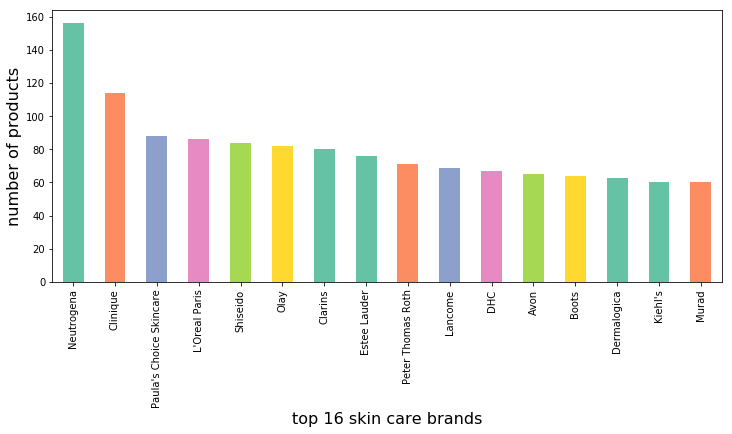

number of body care brands 107


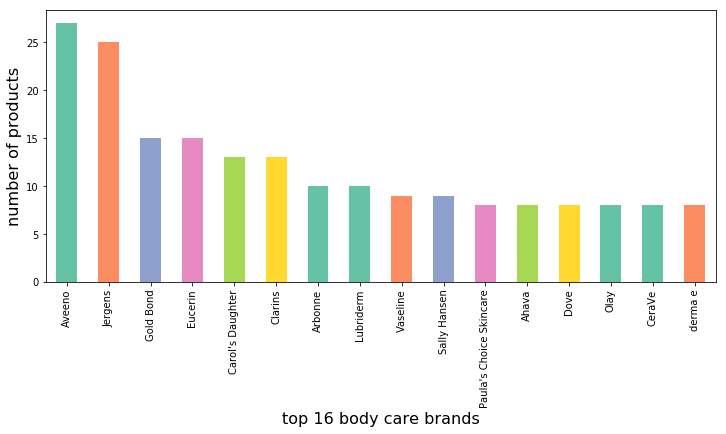

number of makeup brands 132


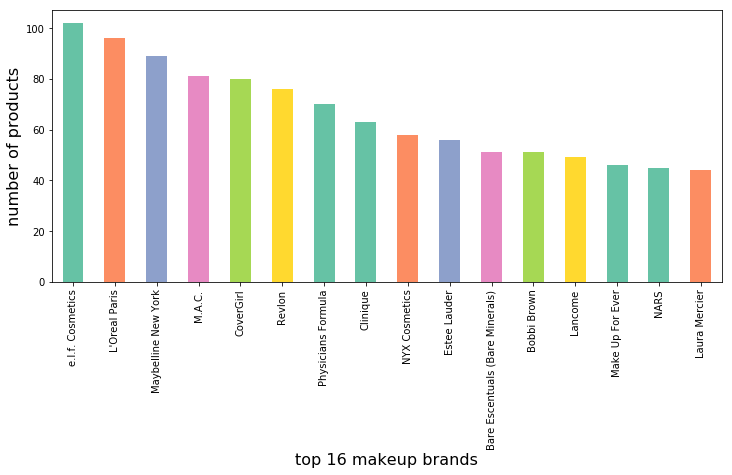

In [9]:
def report_brand(df, message, ntop_brand = 16):
    print ('number of %s brands'%message, df['brand'].nunique())
    count = df.groupby('brand')['product_names'].nunique().sort_values(ascending=False)[:ntop_brand]
    plt.figure(figsize=(12,5))
    count.plot.bar(stacked=True)
    plt.xlabel('top %d %s brands'%(ntop_brand, message), fontsize=16)
    plt.ylabel('number of products', fontsize=16)
    plt.show()
    
report_brand(skin_care_df, 'skin care')
report_brand(body_care_df, 'body care')
report_brand(makeup_df, 'makeup')

#### How price varies with product category

First let's check the overall price distribution for skincare, body care and makeups. We find skin care product price has larges variance; body care price has relatively low variance and in general cheaper.

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


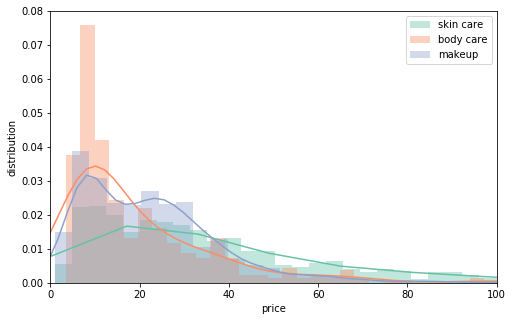

In [10]:
plt.figure(figsize=(8,5))
sns.distplot(skin_care_df['price'], bins=400)
sns.distplot(body_care_df['price'], bins=50)
sns.distplot(makeup_df['price'], bins=50)
plt.xlim(0,100)
plt.ylim(0,0.08)
plt.xlabel('price')
plt.ylabel('distribution')
plt.legend(('skin care','body care','makeup'))
plt.show()

Looking at the price by subcategory, we can identify some expensive product categories: serum, retinol, face oil... and some cheep categories: lip balm, makeup remover, mascara...

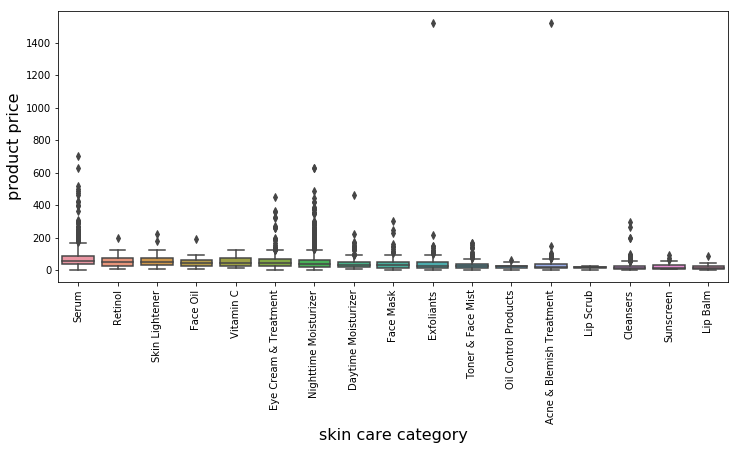

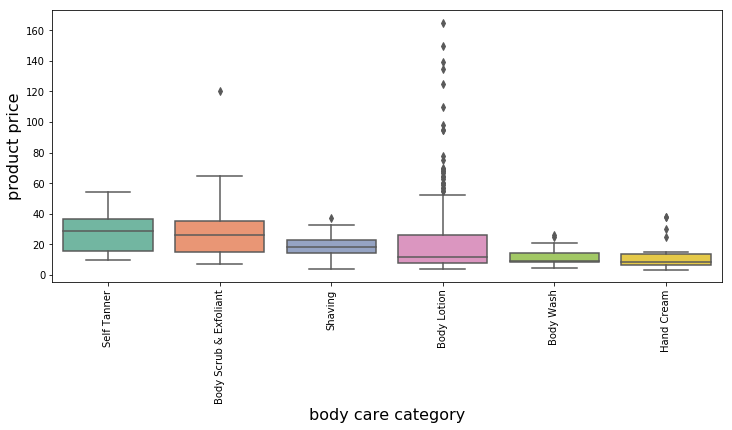

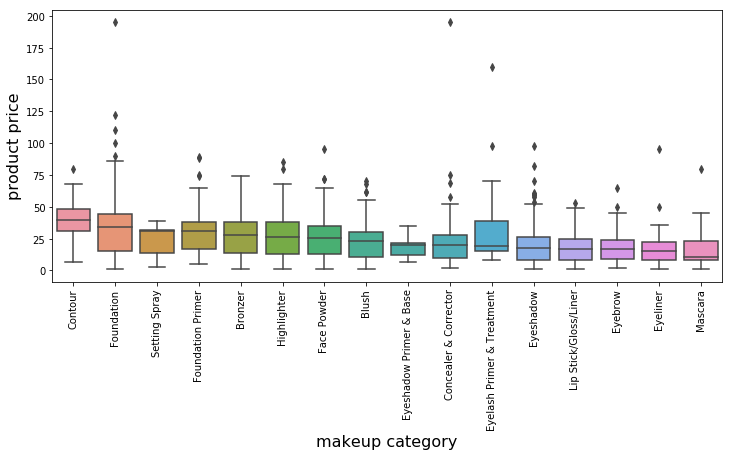

In [11]:
def report_price_by_category(df, message):
    if df['price'].dtype != 'float':
        df['price'] = df['price'].apply(lambda x: x.replace(',','')).astype('float')
    median_price_by_cat = df.groupby('product_category')['price'].median().sort_values(ascending=False)
    plt.figure(figsize=(12,5))
    ax = sns.boxplot(x='product_category', y='price', order=median_price_by_cat.index.values, data=df)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.xlabel('%s category'%message, fontsize=16)
    plt.ylabel('product price', fontsize=16)
    plt.show()
    
report_price_by_category(skin_care_df, 'skin care')
report_price_by_category(body_care_df, 'body care')
report_price_by_category(makeup_df, 'makeup')

We can see usually the price distributions are right skewed, and there are some expensive outliers. Take a look at the skin care product that cost $1500+, it turns out it is actually the same product: "Orchidee Imperiale The Cure 3rd Generation Cure Treatment" from Guerlain...

In [12]:
skin_care_df.iloc[:,:6].loc[skin_care_df['price']>1400]

,product_names,product_category,brand,ingredient,size,price
145,Orchidee Imperiale The Cure 3rd Generation Cur...,Acne & Blemish Treatment,Guerlain,NaN,NaN,1520.0
1493,Orchidee Imperiale The Cure 3rd Generation Cur...,Exfoliants,Guerlain,NaN,NaN,1520.0


But keep in mind we have been looking at the total price, it is worthwhile to consider how much product you get in a product. If we look at the average price (price/volumn), the story might be different. For example, let's check a few categories in skin cares, we now see eye products is the most expensive category, because usually they have a smaller size compare to face products.

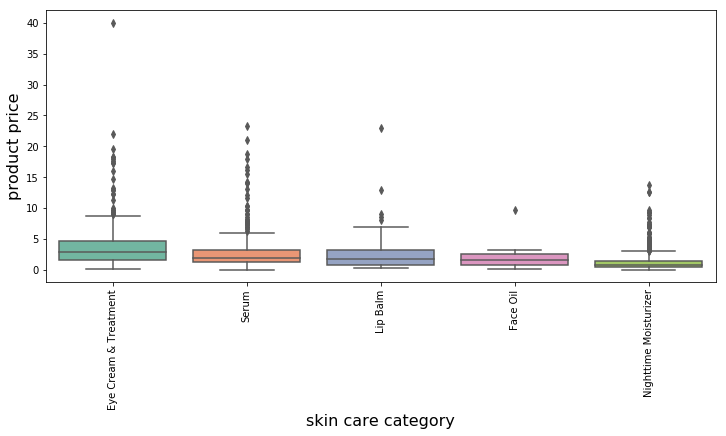

In [13]:
def report_avg_price_by_category(df, message):
    if df['price'].dtype != 'float':
        df['price'] = df['price'].apply(lambda x: x.replace(',','')).astype('float')
    median_price_by_cat = df.groupby('product_category')['avg_price'].median().sort_values(ascending=False)
    plt.figure(figsize=(12,5))
    ax = sns.boxplot(x='product_category', y='avg_price', order=median_price_by_cat.index.values, data=df)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.xlabel('%s category'%message, fontsize=16)
    plt.ylabel('product price', fontsize=16)
    plt.show()
    
cat_list = ['Eye Cream & Treatment', 'Serum', 'Lip Balm', 'Nighttime Moisturizer', 'Face Oil']
report_avg_price_by_category(skin_care_df.loc[(skin_care_df['product_category'].isin(cat_list)) &
                                              (skin_care_df['size_unit']=='ml')], 'skin care')

#### How price varies with brand

Let's turn to price's dependence on brand. We found the most expensive brand like La Mer can easily cost \$200, while there are affordable options from e.l.f, Wet'n Wild, ColourPop..., where you can get a product with just 10 bucks. 

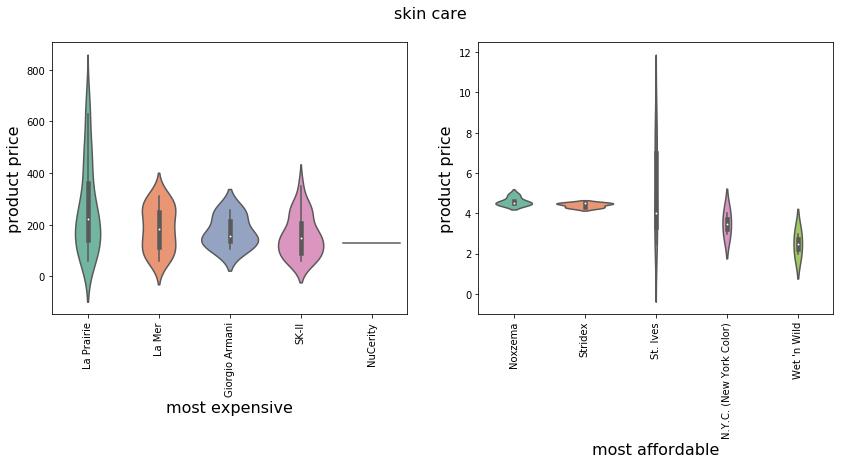

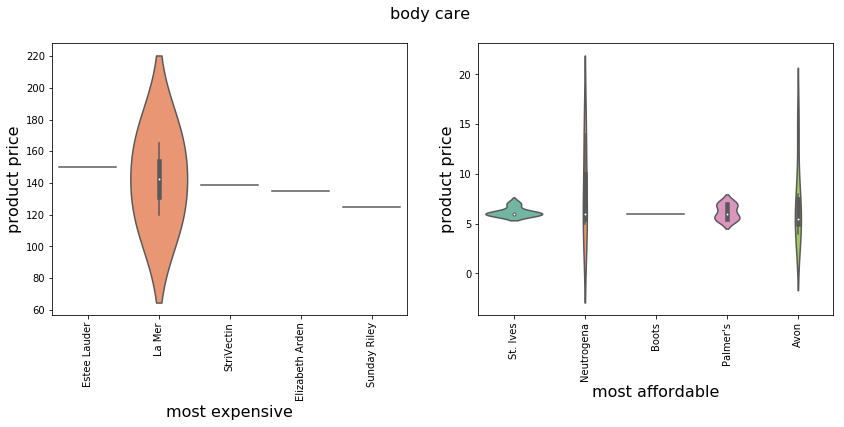

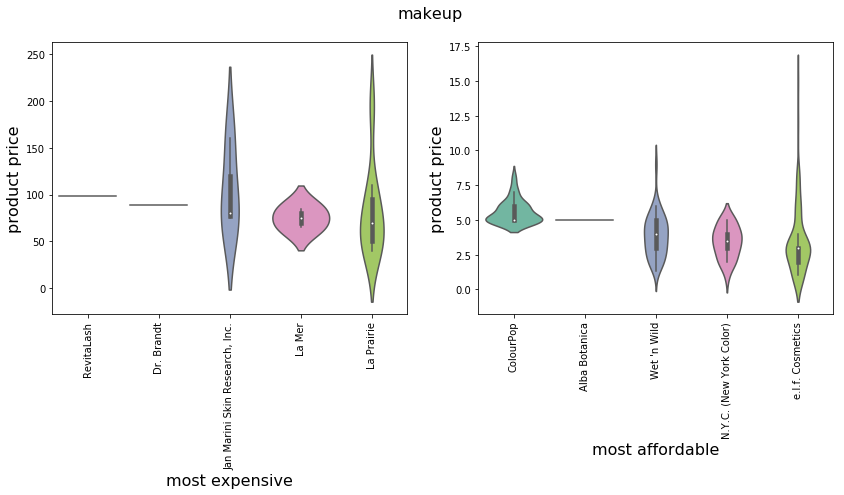

In [14]:
def report_price_by_brand(df, message, ntop=5, nbot=5):
    if df['price'].dtype != 'float':
        df['price'] = df['price'].apply(lambda x: x.replace(',','')).astype('float')
    median_price_by_brand = df.groupby('brand')['price'].median().sort_values(ascending=False)
    
    plt.figure(figsize=(14,5))
    plt.suptitle(message, fontsize=16)
    plt.subplot(1,2,1)
    ax = sns.violinplot(x='brand', y='price', 
                     order=median_price_by_brand.index.values[:ntop],
                     data=df.loc[df['brand'].isin(median_price_by_brand.index.values[:ntop])])
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.xlabel('most expensive', fontsize=16)
    plt.ylabel('product price', fontsize=16)
    
    plt.subplot(1,2,2)
    ax = sns.violinplot(x='brand', y='price', 
                     order=median_price_by_brand.index.values[-nbot:],
                     data=df.loc[df['brand'].isin(median_price_by_brand.index.values[-nbot:])])
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.xlabel('most affordable', fontsize=16)
    plt.ylabel('product price', fontsize=16)
    plt.show()
    
report_price_by_brand(skin_care_df, 'skin care')
report_price_by_brand(body_care_df, 'body care')
report_price_by_brand(makeup_df, 'makeup')

#### How price varies with ingredient

There is no single metric to evaluate a product's formula. We will start with simple ideas:

* number of ingredients in a product --- if a product contains a long list of product, it may be more likely that the company has spend some time on this sophisticated formula and the product might be expensive.

* since we have rated the ingredient using the ingredient dictionary on [Paula's choice](https://www.paulaschoice.com/ingredient-dictionary) website, we can compute the average rating of each product and see if it is related to the price.

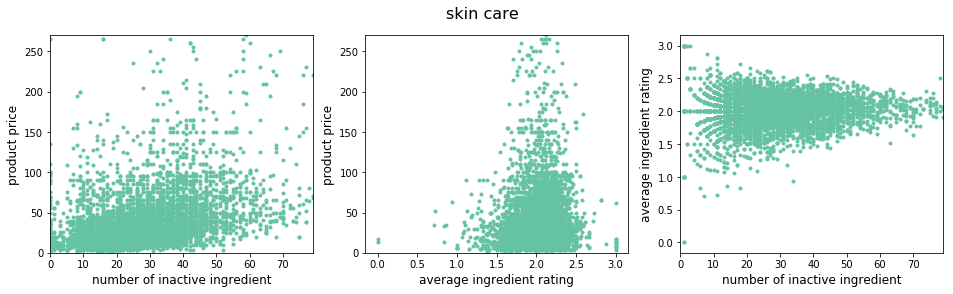

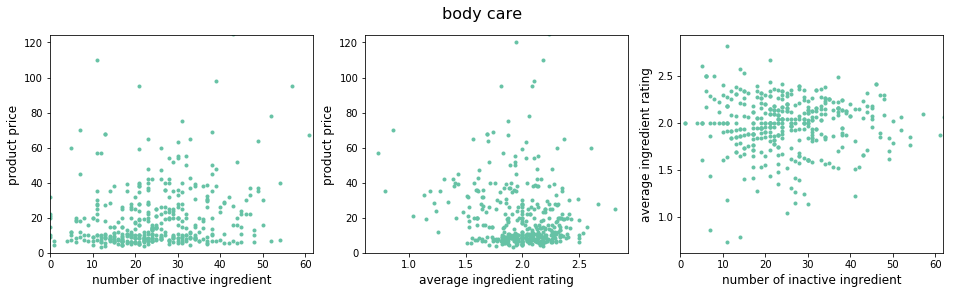

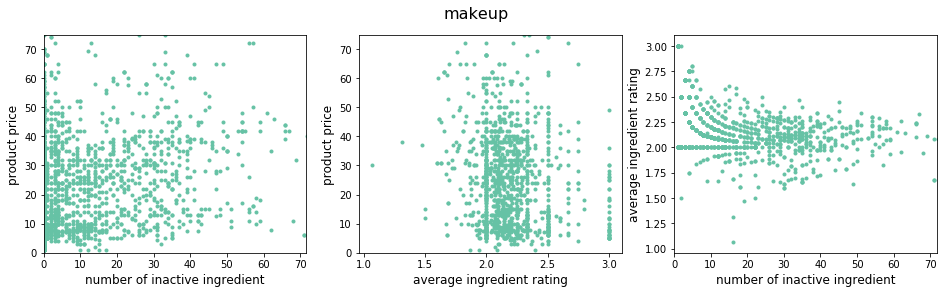

In [15]:
def report_price_by_ingredient(df, message):
    plt.figure(figsize=(16,4))
    plt.suptitle(message, fontsize=16)
    plt.subplot(1,3,1)
    plt.scatter(df['n_inactive_ingredient'], df['price'], marker='.')
    plt.xlim(0, df['n_inactive_ingredient'].quantile(0.99))
    plt.ylim(0, df['price'].quantile(0.99))
    plt.xlabel('number of inactive ingredient', fontsize=12)
    plt.ylabel('product price', fontsize=12)
    
    plt.subplot(1,3,2)
    plt.scatter(df['inactive_mean_rating'], df['price'], marker='.')
    plt.ylim(0, df['price'].quantile(0.99))
    plt.xlabel('average ingredient rating', fontsize=12)
    plt.ylabel('product price', fontsize=12)
    
    plt.subplot(1,3,3)
    plt.scatter(df['n_inactive_ingredient'], df['inactive_mean_rating'], marker='.')
    plt.xlim(0, df['n_inactive_ingredient'].quantile(0.99))
    plt.xlabel('number of inactive ingredient', fontsize=12)
    plt.ylabel('average ingredient rating', fontsize=12)
   
    plt.show()
    
report_price_by_ingredient(skin_care_df, 'skin care')
report_price_by_ingredient(body_care_df, 'body care')
report_price_by_ingredient(makeup_df, 'makeup')

So we find in skin care product, there seem to be a trend (although not very strong) that products with more ingredients are more expensive. This trend does not appear in body care and makeups, which makes sense: people usually don't expect body care products to have functions such as anti-aging, pore-reducing, anti-acne, etc like for skin cares. It may be more important for a body care product to smell good and have some basic hydration effect, and that does not need a lot of ingredients. For makeups, people may care more about the packaging, whether the color suit..., again these concerns are not strongly related to ingredient.

We don't see a strong correlation between average ingredient rating and product price, even for skin care products. Also, it seems like more ingredient doesn't mean "good" ingredient. However, we are not going to draw a conclusion without further investication, we haven't consider ingredient's quantity in products, the ingredient rating may not be the best.

#### How price varies with ingredient category

Now let's examine the correlation between price and different ingredient categories. We will calculate the pearson correlation between price and the count of ingredient for each category in products, and identify the categories with highest correlation with price. Some of these categories are: skin restoring ingredients, antioxidants...

In [16]:
def report_price_ingredient_cat(df, message):
    print('In %s, ingredient categories that mostly correlated to price:'%message)
    cols = [f_ for f_ in df.columns.values if f_.find('inactive_cat_count_')>=0]
    corr = pd.Series(name='correlation with price')
    for col in cols:
        corr[col[19:]] = df[col].corr(df['price'])
    corr = corr.sort_values(ascending=False)[:5]
    print(corr)
    print('\n')

report_price_ingredient_cat(skin_care_df, 'skin care')
report_price_ingredient_cat(body_care_df, 'body care')
report_price_ingredient_cat(makeup_df, 'makeup')

In skin care, ingredient categories that mostly correlated to price:
Skin-Restoring       0.323098
Texture Enhancer     0.292013
Antioxidants         0.291370
Emollients           0.239516
Skin-Replenishing    0.232229
Name: correlation with price, dtype: float64


In body care, ingredient categories that mostly correlated to price:
Antioxidants                                        0.399685
Plant Extracts                                      0.359103
Skin-Restoring                                      0.298236
Hydration                                           0.255935
Fragrance: Synthetic and Fragrant Plant Extracts    0.241111
Name: correlation with price, dtype: float64


In makeup, ingredient categories that mostly correlated to price:
Plant Extracts       0.295889
Skin-Replenishing    0.288737
Antioxidants         0.275577
Skin-Restoring       0.247236
Sensitizing          0.243132
Name: correlation with price, dtype: float64




So are these "expensive" categories of ingredient good? We should check the ingredient rating by category. If they are rated high, then it makes sense for products containing these ingredient expensive. If not, we are alerted that expensive products might not necessarily have good ingredient, or we need to rethink our rating system.

* First have a brief look at the rating:

In [17]:
cols = ['name','rating','rating_num']
ingredient_df = pd.read_csv('../data_cleaning/ingredient_cleaned.csv', usecols=cols)
print('average rating: %.4f (Poor:0, Average:1, Good:2, Best:3'%ingredient_df['rating_num'].mean())
ingredient_df['rating'].value_counts()

average rating: 1.8566 (Poor:0, Average:1, Good:2, Best:3


Good       879
Best       447
Poor       275
Average    148
GOOD         1
Name: rating, dtype: int64

* Ingredient rating by category: 

The rating mostly make sense, we know vitamins, antioxidants are good for skin, while sensitizing ingredients and fragrance are usually not. So, its good to know that some highly rated categories like skin-Restoring, antioxidants are positively correlated to price, but also keep in mind that low-rating categories like plant extract and fragrence also appear in the list of categories with high correlation with price.

In [18]:
ingredient_single_cat = pd.read_csv('../data_cleaning/ingredient_single_cat.csv')
ingredient_single_cat.groupby('category')['rating_num'].mean().sort_values(ascending=False)

category
Anti-Acne                                           3.000000
Skin-Restoring                                      2.808824
Vitamins                                            2.600000
Skin-Replenishing                                   2.558559
Sunscreen Actives                                   2.478261
Exfoliant                                           2.423077
Skin-Soothing                                       2.380000
Antioxidants                                        2.261044
Emollients                                          2.236467
Film-Forming Agents                                 2.200000
Hydration                                           2.138889
Skin-Softening                                      2.121212
Emulsifiers                                         2.038462
Slip Agents                                         2.000000
Thickeners                                          2.000000
Silicones                                           2.000000
Film-Forming/Ho

#### Cumulative Distribution of Ingredient Frequency

x axis: number of products containing an ingredient. y axis: the percentage of ingredient that appear less than x times.

This give us an idea of how many ingredients exist just in a few products, and how many ingredients exist almost every where.

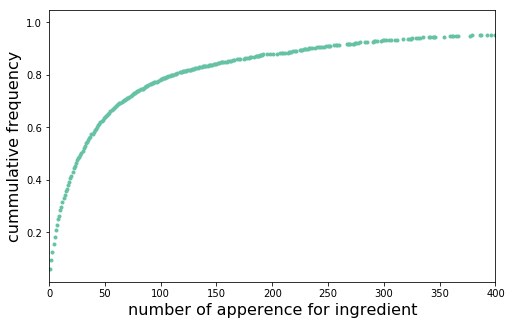

In [19]:
df = pd.concat([skin_care_df,body_care_df,makeup_df], sort=False).reset_index(drop=True)
df = df.loc[~df['ingredient'].isnull()]
df = df.groupby(['product_names','brand']).first()
ingredient_count_df = get_matching_ingredient_count(df)

cumfreq = ingredient_count_df.sum().value_counts().sort_index().cumsum()
cumfreq = cumfreq/cumfreq.max()

plt.figure(figsize=(8,5))
cumfreq.plot.line(style=['.'])
plt.xlim(0,400)
plt.xlabel("number of apperence for ingredient", fontsize=16)
plt.ylabel("cummulative frequency", fontsize=16)
plt.show()

#### Word Cloud for Fun!

Ingredient in skin care...

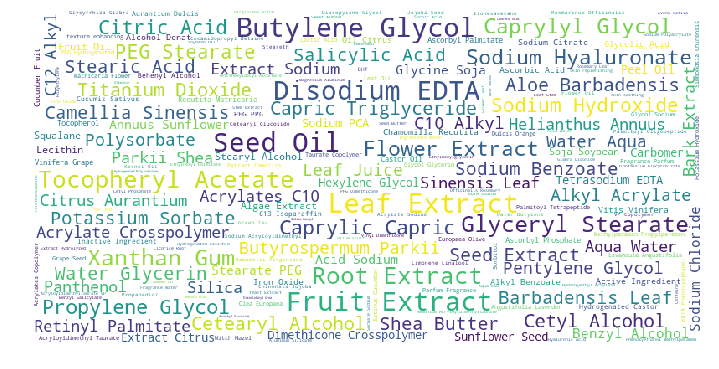

In [20]:
from wordcloud import WordCloud
tmp = skin_care_df.ingredient.fillna(' ')
text = ' '.join(tmp)
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      max_font_size=32,
                      width=800, 
                      height=400).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

claims of skin care products...

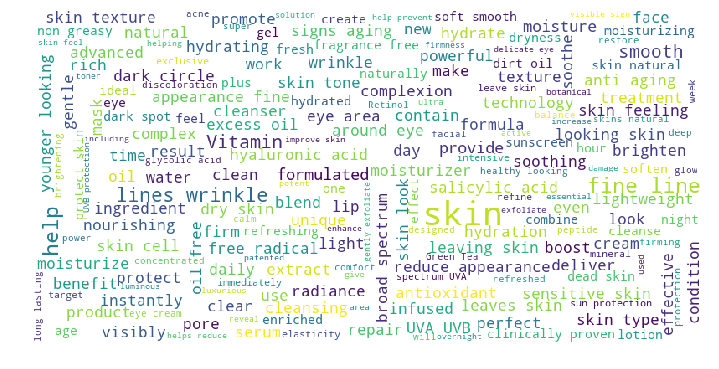

In [21]:
tmp = skin_care_df.claims.fillna(' ')
text = ' '.join(tmp)
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      max_font_size=40,
                      width=800, 
                      height=400).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()